In [1]:
import numpy as np
import pandas as pd
import math

In [2]:
class TreeNode:
    def __init__(self, data,output):
        # data represents the feature upon which the node was split when fitting the training data
        # data = None for leaf node
        self.data = data
        # children of a node are stored as a dicticionary with key being the value of feature upon which the node was split
        # and the corresponding value stores the child TreeNode
        self.children = {}
        # output represents the class with current majority at this instance of the decision tree
        self.output = output
        # index will be used to assign a unique index to each node
        self.index = -1
        
    def add_child(self,feature_value,obj):
        self.children[feature_value] = obj

In [3]:
class DecisionTreeClassifier:
    def __init__(self):
        # root represents the root node of the decision tree built after fitting the training data
        self.__root = None

    def __count_unique(self,Y):
        # returns a dictionary with keys as unique values of Y(i.e no of classes) and the corresponding value as its frequency
        d = {}
        for i in Y:
            if i not in d:
                d[i]=1
            else:
                d[i]+=1
        return d


    def __entropy(self,Y):
        # returns the entropy 
        freq_map = self.__count_unique(Y)
        entropy_ = 0
        total = len(Y)
        for i in freq_map:
            p = freq_map[i]/total
            entropy_ += (-p)*math.log2(p)
        return entropy_

    def __gain_ratio(self,X,Y,selected_feature):
        # returns the gain ratio
        info_orig = self.__entropy(Y) # info_orig represents entropy before splitting
        info_f = 0  # info_f represents entropy after splitting upon the selected feature
        split_info = 0
        values = set(X[:,selected_feature])
        df = pd.DataFrame(X)
        # Adding Y values as the last column in the dataframe 
        df[df.shape[1]] = Y
        initial_size = df.shape[0] 
        for i in values:
            df1 = df[df[selected_feature] == i]
            current_size = df1.shape[0]
            info_f += (current_size/initial_size)*self.__entropy(df1[df1.shape[1]-1])
            split_info += (-current_size/initial_size)*math.log2(current_size/initial_size)

        # to handle the case when split info = 0 which leads to division by 0 error
        if split_info == 0 :
            return math.inf

        info_gain = info_orig - info_f
        gain_ratio = info_gain / split_info
        return gain_ratio

    def __gini_index(self,Y):
        # returns the gini index 
        freq_map = self.__count_unique(Y)
        gini_index_ = 1
        total = len(Y)
        for i in freq_map:
            p = freq_map[i]/total
            gini_index_ -= p**2
        return gini_index_

    def __gini_gain(self,X,Y,selected_feature):
        # returns the gini gain
        gini_orig = self.__gini_index(Y) # gini_orig represents gini index before splitting
        gini_split_f = 0 # gini_split_f represents gini index after splitting upon the selected feature
        values = set(X[:,selected_feature])
        df = pd.DataFrame(X)
        # Adding Y values as the last column in the dataframe 
        df[df.shape[1]] = Y
        initial_size = df.shape[0] 
        for i in values:
            df1 = df[df[selected_feature] == i]
            current_size = df1.shape[0]
            gini_split_f += (current_size/initial_size)*self.__gini_index(df1[df1.shape[1]-1])

        gini_gain_ = gini_orig - gini_split_f
        return gini_gain_


    def __decision_tree(self,X,Y,features,level,metric,classes):
        # returns the root of the Decision Tree(which consists of TreeNodes) built after fitting the training data
        # Here Nodes are printed as in PREORDER traversl
        # classes represents the different classes present in the classification problem 
        # metric can take value gain_ratio or gini_index
        # level represents depth of the tree
        # We split a node on a particular feature only once (in a given root to leaf node path)
        
        
        # If the node consists of only 1 class
        if len(set(Y)) == 1:
            print("Level",level)
            output = None
            for i in classes:
                if i in Y:
                    output = i
                    print("Count of",i,"=",len(Y))
                else :
                    print("Count of",i,"=",0)
            if metric == "gain_ratio":
                print("Current Entropy is =  0.0")
            elif metric == "gini_index":
                print("Current Gini Index is =  0.0")

            print("Reached leaf Node")
            print()
            return TreeNode(None,output)

        # If we have run out of features to split upon
        # In this case we will output the class with maximum count
        if len(features) == 0:
            print("Level",level)
            freq_map = self.__count_unique(Y)
            output = None
            max_count = -math.inf
            for i in classes:
                if i not in freq_map:
                    print("Count of",i,"=",0)
                else :
                    if freq_map[i] > max_count :
                        output = i
                        max_count = freq_map[i]
                    print("Count of",i,"=",freq_map[i])

            if metric == "gain_ratio":
                print("Current Entropy  is =",self.__entropy(Y))
            elif metric == "gini_index":
                print("Current Gini Index is =",self.__gini_index(Y))            

            print("Reached leaf Node")
            print()
            return TreeNode(None,output)

        
        # Finding the best feature to split upon
        max_gain = -math.inf
        final_feature = None
        for f in features :
            if metric == "gain_ratio":
                current_gain = self.__gain_ratio(X,Y,f)
            elif metric =="gini_index":
                current_gain = self.__gini_gain(X,Y,f)

            if current_gain > max_gain:
                max_gain = current_gain
                final_feature = f

        print("Level",level)
        freq_map = self.__count_unique(Y)
        output = None
        max_count = -math.inf

        for i in classes:
            if i not in freq_map:
                print("Count of",i,"=",0)
            else :
                if freq_map[i] > max_count :
                    output = i
                    max_count = freq_map[i]
                print("Count of",i,"=",freq_map[i])

        if metric == "gain_ratio" :        
            print("Current Entropy is =",self.__entropy(Y))
            print("Splitting on feature  X[",final_feature,"] with gain ratio ",max_gain,sep="")
            print()
        elif metric == "gini_index":
            print("Current Gini Index is =",self.__gini_index(Y))
            print("Splitting on feature  X[",final_feature,"] with gini gain ",max_gain,sep="")
            print()

            
        unique_values = set(X[:,final_feature]) # unique_values represents the unique values of the feature selected
        df = pd.DataFrame(X)
        # Adding Y values as the last column in the dataframe
        df[df.shape[1]] = Y

        current_node = TreeNode(final_feature,output)

        # Now removing the selected feature from the list as we do not want to split on one feature more than once(in a given root to leaf node path)
        index  = features.index(final_feature)
        features.remove(final_feature)
        for i in unique_values:
            # Creating a new dataframe with value of selected feature = i
            df1 = df[df[final_feature] == i]
            # Segregating the X and Y values and recursively calling on the splits
            node = self.__decision_tree(df1.iloc[:,0:df1.shape[1]-1].values,df1.iloc[:,df1.shape[1]-1].values,features,level+1,metric,classes)
            current_node.add_child(i,node)

        # Add the removed feature     
        features.insert(index,final_feature)

        return current_node
    
    def fit(self,X,Y,metric="gain_ratio"):
        # Fits to the given training data
        # metric can take value gain_ratio or gini_index
        features = [i for i in range(len(X[0]))]
        classes = set(Y)
        level = 0
        if metric != "gain_ratio" :
            if metric != "gini_index":
                metric="gain_ratio"  # if user entered a value which was neither gini_index nor gain_ratio
        self.__root = self.__decision_tree(X,Y,features,level,metric,classes)
        
    def __predict_for(self,data,node):
        # predicts the class for a given testing point and returns the answer
        
        # We have reached a leaf node
        if len(node.children) == 0 :
            return node.output

        val = data[node.data] # represents the value of feature on which the split was made       
        if val not in node.children :
            return node.output
        
        # Recursively call on the splits
        return self.__predict_for(data,node.children[val])

    def predict(self,X):
        # This function returns Y predicted
        # X should be a 2-D np array
        Y = np.array([0 for i in range(len(X))])
        for i in range(len(X)):
            Y[i] = self.__predict_for(X[i],self.__root)
        return Y
    
    def score(self,X,Y):
        # returns the mean accuracy
        Y_pred = self.predict(X)
        count = 0
        for i in range(len(Y_pred)):
            if Y_pred[i] == Y[i]:
                count+=1
        return count/len(Y_pred)
    
    def export_tree_pdf(self,filename=None):
        # returns the tree as dot data
        # if filename is specified the function 
        # will save the pdf file in current directory which consists of the visual reresentation of the tree
        import pydotplus
        from collections import deque
        
        dot_data = '''digraph Tree {
node [shape=box] ;'''
        
        queue = deque()
        
        r = self.__root
        queue.append(r)
        count = 0
        if r.index == -1:
            r.index = count
        
        dot_data = dot_data + "\n{} [label=\"Feature to split upon : X[{}]\\nOutput at this node : {}\" ];".format(count,r.data,r.output) 
        
        # Doing LEVEL ORDER traversal in the tree (using a queue)
        while len(queue) != 0 :
            node = queue.popleft()
            for i in node.children:
                count+=1
                if(node.children[i].index==-1):
                    node.children[i].index = count
                
                # Creating child node
                dot_data = dot_data + "\n{} [label=\"Feature to split upon : X[{}]\\nOutput at this node : {}\" ];".format(node.children[i].index,node.children[i].data,node.children[i].output) 
                # Connecting parent node with child
                dot_data = dot_data + "\n{} -> {} [ headlabel=\"Feature value = {}\"]; ".format(node.index,node.children[i].index,i)
                # Adding child node to queue
                queue.append(node.children[i])
        
        dot_data = dot_data + "\n}"

        if filename != None:    
            graph = pydotplus.graph_from_dot_data(dot_data)
            graph.write_pdf(filename)    
        
        return dot_data

In [4]:
clf1 = DecisionTreeClassifier()

x = np.array([[0,0],
              [0,1],
              [1,0],
              [1,1]])

y = np.array([0,
              1,
              1,
              1]) 
clf1.fit(x,y)
Y_pred = clf1.predict(x)
print("Predictions :",Y_pred)
print()
print("Score :",clf1.score(x,y)) # Score on training data
print()

Level 0
Count of 0 = 1
Count of 1 = 3
Current Entropy is = 0.8112781244591328
Splitting on feature  X[0] with gain ratio 0.31127812445913283

Level 1
Count of 0 = 1
Count of 1 = 1
Current Entropy is = 1.0
Splitting on feature  X[1] with gain ratio 1.0

Level 2
Count of 0 = 1
Count of 1 = 0
Current Entropy is =  0.0
Reached leaf Node

Level 2
Count of 0 = 0
Count of 1 = 1
Current Entropy is =  0.0
Reached leaf Node

Level 1
Count of 0 = 0
Count of 1 = 2
Current Entropy is =  0.0
Reached leaf Node

Predictions : [0 1 1 1]

Score : 1.0



In [6]:
# testing our code with a dataset from sklearn
from sklearn import datasets
# Generating a random dataset
X,Y = datasets.make_classification(n_samples=100, n_features=5, n_classes=3,n_informative=3 , random_state=0)
# To reduce the values a feature can take ,converting floats to int
for i in range(len(X)):
    for j in range(len(X[0])):
        X[i][j] = int(X[i][j])
        
clf2 = DecisionTreeClassifier()
clf2.fit(X,Y,metric='gini_index')
Y_pred2 = clf2.predict(X)
print("Predictions : ",Y_pred2)



Level 0
Count of 0 = 34
Count of 1 = 32
Count of 2 = 34
Current Gini Index is = 0.6663999999999999
Splitting on feature  X[4] with gini gain 0.17473071690214542

Level 1
Count of 0 = 15
Count of 1 = 19
Count of 2 = 15
Current Gini Index is = 0.6622240733027904
Splitting on feature  X[2] with gini gain 0.22894306859321423

Level 2
Count of 0 = 5
Count of 1 = 5
Count of 2 = 3
Current Gini Index is = 0.650887573964497
Splitting on feature  X[0] with gini gain 0.21499013806706113

Level 3
Count of 0 = 4
Count of 1 = 2
Count of 2 = 0
Current Gini Index is = 0.4444444444444444
Splitting on feature  X[1] with gini gain 0.0

Level 4
Count of 0 = 4
Count of 1 = 2
Count of 2 = 0
Current Gini Index is = 0.4444444444444444
Splitting on feature  X[3] with gini gain 0.0

Level 5
Count of 0 = 4
Count of 1 = 2
Count of 2 = 0
Current Gini Index is = 0.4444444444444444
Reached leaf Node

Level 3
Count of 0 = 0
Count of 1 = 1
Count of 2 = 0
Current Gini Index is =  0.0
Reached leaf Node

Level 3
Count of

In [7]:
our_score = clf2.score(X,Y)
print("Score :",our_score) # score on training data


Score : 0.88


In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay?

In [12]:
cm = confusion_matrix(Y_pred2,Y)
disp= ConfusionMatrixDisplay(confusion_matrix=cm)

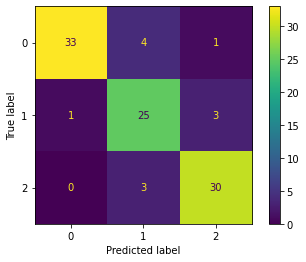

In [14]:
disp.plot()